In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment import PricingEnvironment
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB
from learners.pricing.contextual_learner import ContextualLearner
from environments.contextual_environment import ContextualEnvironment
from utils.context_generator import ContextGenerator

In [2]:
dg = BasicDataGenerator(filename='src/test_values.json')
sel_bid = 3
fixed_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[sel_bid]).astype(int)
fixed_cost = dg.get_costs_per_click(mode='aggregate')[sel_bid]
env_params = {
    'features': dg.get_features(),
    'customer_classes': dg.get_classes(),
    'conversion_rates': dg.get_conversion_rates(mode='all'),
    'future_purchases': dg.get_future_purchases(mode='all'),
    'daily_clicks': fixed_clicks,
    'cost_per_click': fixed_cost
}
margins = dg.get_margins()
fractions = []
for cl in dg.get_classes().values():
    fractions.append(cl['fraction'])

args = {
    'arm_values': dg.get_margins()
}

In [3]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [4]:
opt_arms = []
global_opt = 0

for i, conv_rate in enumerate(dg.get_conversion_rates(mode='all')):
    opt_arm = np.argmax(margins[i] * conv_rate * (1 + dg.get_future_purchases()[i]) - fixed_cost)
    opt_value = np.max(margins[i] * conv_rate * (1 + dg.get_future_purchases()[i]) - fixed_cost)
    opt_arms.append((opt_arm, opt_value))
    global_opt += fractions[i]*opt_value

print(f'N_ARMS: {len(margins)}')
print(f'Optimal arm: {str(opt_arms)}')
print(f'Fractions: {fractions}')
print(f'Global opt: {global_opt}')

N_ARMS: 10
Optimal arm: [(0, 41.153), (0, 8.063), (0, 14.183)]
Fractions: [0.2, 0.35, 0.45]
Global opt: 17.435


In [5]:
learners_to_test = [ThompsonSampling, UCB]
rewards_per_experiment = {}
context_split_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_experiment[learner.LEARNER_NAME] = []

print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')
print(f'ALGORITHMS: {list(rewards_per_experiment.keys())}')
start_from = 60
frequency = 15
confidence = 0.001

N_ROUNDS: 365
N_EXPERIMENTS: 10
ALGORITHMS: ['TS-Pricing', 'UCB-Pricing']


In [6]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'running exp#{e}...')
    test_instances = []
    for learner in learners_to_test:
        context_learner = ContextualLearner(dg.get_features(), learner, **args)
        test_instances.append(
            (context_learner,
            ContextualEnvironment(**env_params),
            ContextGenerator(dg.get_features(), context_learner, update_frequency=frequency, start_from=start_from, confidence=confidence))
        )
        
    for t in range(T):
        for context_learner, env, context_generator  in test_instances:
            context_learner.next_day()
            past_arms = None
            past_features = None
            month_purchases = env.get_next_purchases_at_day(t, keep=False)
            if month_purchases is not None:
                past_arms = env.get_selected_arms_at_day(t - 30, keep=False)
                past_features= env.get_collected_user_features_at_day(t - 30, keep=False)
                context_learner.update_next_purchases(past_arms,
                                                      month_purchases, 
                                                      past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards = env.day_round(pulled_arms)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)

            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, daily_rewards, daily_users_features, 
                                                 next_purchases=month_purchases, past_pulled_arms=past_arms, past_features=past_features)
        
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())

running exp#0...

-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.94250441399194, 16.933060822371896]
	Value before the split: 17.90908988532443


-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.360230239999916, 15.057429244003544]
	Value before the split: 15.591969278969835


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2

Analysis of the feature `feature-1`...
	Values after the split: [12.336376647826016, 13.6014681625559]
	Value before the split: 16.838527831690392


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.235023894042016, 16.48031940170284]
	Value before the split: 16.64448224012111


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.35380573205694, 9.95065850278173]
	Value before the split: 16.82324520360858


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluat

Analysis of the feature `feature-1`...
	Values after the split: [12.325168149893507, 9.927890471559198]
	Value before the split: 16.34513106180606

running exp#1...

-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.28652850576497, 16.66580120198542]
	Value before the split: 17.140079016166755


-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [14.732760604728913, 15.06600260684503]
	Value before the split: 16.397191909671047


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LE

Analysis of the feature `feature-1`...
	Values after the split: [12.423234098214781, 12.518033959180428]
	Value before the split: 16.66459000136004


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.290488377661546, 16.69404510798312]
	Value before the split: 16.74718302848904


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.68621033628725, 12.60755028771279]
	Value before the split: 16.620476676055546


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Eval

Analysis of the feature `feature-1`...
	Values after the split: [12.432974240700887, 15.578159208452366]
	Value before the split: 14.468979948626977

	best_feature='feature-1'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False} and {'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.2171933910952, 16.122558038693498]
	Value before the split: 16.966533738359033


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [7.0004950904155]
	Value before the split: 10.508623612961976

- Evaluating the Node: feature_subsp

	Values after the split: [3.120282758758486]
	Value before the split: 10.76300957190279

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [19.61058053881014]
	Value before the split: 23.795765206564926


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.120127972025028, 16.111288561387628]
	Value before the split: 16.581385821531946


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [4.581656958078551]
	Value befo

	Values after the split: [4.535878538247713]
	Value before the split: 10.761608578468838

running exp#3...

-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [14.975002954066003, 14.695367191852183]
	Value before the split: 15.441260253033107


-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [14.255249139664654, 14.732796437923955]
	Value before the split: 18.07740725064238


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_

Analysis of the feature `feature-1`...
	Values after the split: [12.150411731603386, 13.113660168331556]
	Value before the split: 16.69416952221194


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.43238116010317, 16.449291100822975]
	Value before the split: 16.91926802384929


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.099365026921632, 12.998668333990478]
	Value before the split: 16.694047167180067


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Ev

Analysis of the feature `feature-1`...
	Values after the split: [14.195809257992991, 11.552727324809009]
	Value before the split: 16.127477929283813


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.501330420803164, 16.33672232069497]
	Value before the split: 17.170134215996814


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [14.302622913314051, 13.826981929525452]
	Value before the split: 17.31809373809129


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Eval

Analysis of the feature `feature-1`...
	Values after the split: [12.736088539599747, 11.957543892561883]
	Value before the split: 16.864076516136166


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.58311612946491, 16.60015273844332]
	Value before the split: 17.05049571077022


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [13.593039343974342, 11.96139137235344]
	Value before the split: 17.048521376929013


-------------------- RUNNING CONTEXT GENERATOR@t=255 --------------------
N_LEAVES: 1
- Eva

	Values after the split: [16.034958996920075, 16.205144096486947]
	Value before the split: 16.92515466325353


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [8.637984948309636]
	Value before the split: 11.716982591842518

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [19.97478645218616]
	Value before the split: 24.00944938132568


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.28239576551628, 16.16940861128


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.513635449105323, 16.471533184677433]
	Value before the split: 16.91940030469346


-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [4.158541721373016]
	Value before the split: 10.326400891433128

- Evaluating the Node: feature_subspace={'feature-1': True} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [18.2956499081065]
	Value before the split: 24.253793247972673


-------------------- RUNNING CONTEXT GENERATOR@t=225 ---

Analysis of the feature `feature-1`...
	Values after the split: [16.942344499601965, 15.989212028730664]
	Value before the split: 17.365816118436637


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.314084733203295, 16.170248933463217]
	Value before the split: 16.834509155644085


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [14.744831709279811, 14.366465442663426]
	Value before the split: 16.722337878464884


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Ev

Analysis of the feature `feature-1`...
	Values after the split: [9.47144499152907, 12.083478909992342]
	Value before the split: 16.609980854223522


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [11.623457879618176]
	Value before the split: 12.008905671488193

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [23.664815342820567]
	Value before the split: 24.623401600917457


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after th

Analysis of the feature `feature-1`...
	Values after the split: [15.19851577330742, 14.392190898557192]
	Value before the split: 15.875885049430233


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.192147636703993, 16.109930731967218]
	Value before the split: 16.328474375083907


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.136252241720571, 11.727796040508672]
	Value before the split: 16.392650139364918


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Eva

Analysis of the feature `feature-1`...
	Values after the split: [12.516653314876553, 11.220143500127861]
	Value before the split: 15.064795427240524


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.570551389420473, 16.626393879659254]
	Value before the split: 16.72710483822618


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.48735265171778, 11.150856525965457]
	Value before the split: 16.900099953321728


-------------------- RUNNING CONTEXT GENERATOR@t=255 --------------------
N_LEAVES: 1
- E

Analysis of the feature `feature-1`...
	Values after the split: [12.645888769779123, 12.289113925059453]
	Value before the split: 16.110442301094167


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.820992715711885, 16.790057022599573]
	Value before the split: 17.586056043639203


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [12.874926907126003, 11.153382910387585]
	Value before the split: 16.774296668027663


-------------------- RUNNING CONTEXT GENERATOR@t=105 --------------------
N_LEAVES: 1
- E

Analysis of the feature `feature-1`...
	Values after the split: [11.690354109276692, 12.27030559984053]
	Value before the split: 16.84002816220093


-------------------- RUNNING CONTEXT GENERATOR@t=255 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.60411448470602, 16.608366222748135]
	Value before the split: 17.06165437055887


-------------------- RUNNING CONTEXT GENERATOR@t=255 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [10.154598211695486, 12.305130107693643]
	Value before the split: 16.867522530964955


-------------------- RUNNING CONTEXT GENERATOR@t=270 --------------------
N_LEAVES: 1
- Eva

	Values after the split: [8.065199488923426]
	Value before the split: 10.3659583106919

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [18.552907712008672]
	Value before the split: 24.79360297674779


-------------------- RUNNING CONTEXT GENERATOR@t=105 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.69845745328011, 16.825020669661416]
	Value before the split: 16.909982930928113


-------------------- RUNNING CONTEXT GENERATOR@t=105 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [5.3712233587129425]
	Value befor

	Values after the split: [6.778177280851846]
	Value before the split: 7.956721247545008

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [18.770446483108458]
	Value before the split: 23.941323398336827


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']
Analysis of the feature `feature-2`...
Analysis of the feature `feature-1`...
	Values after the split: [16.49965887290514, 16.64547063296108]
	Value before the split: 16.807312328518623


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [4.330953994747833]
	Value befor

	Values after the split: [2.703073478441045]
	Value before the split: 10.623343884133126

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [18.434488842254183]
	Value before the split: 23.695390118074318



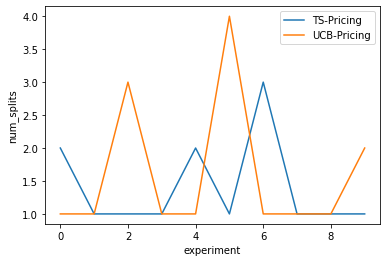

In [7]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_experiment.keys())
plt.show()

In [8]:
for key in context_split_experiment:
    print(f'{key}: avg splits -> {np.mean(context_split_experiment[key])}')

TS-Pricing: avg splits -> 1.4
UCB-Pricing: avg splits -> 1.6


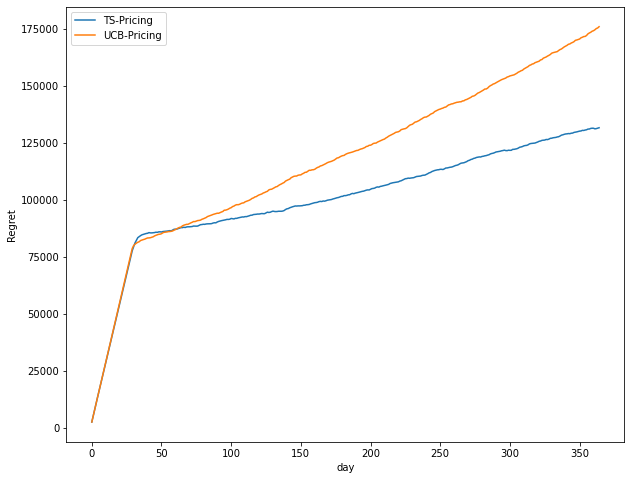

In [9]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
opt = global_opt * fixed_clicks
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(rewards_per_experiment.keys())
plt.show()

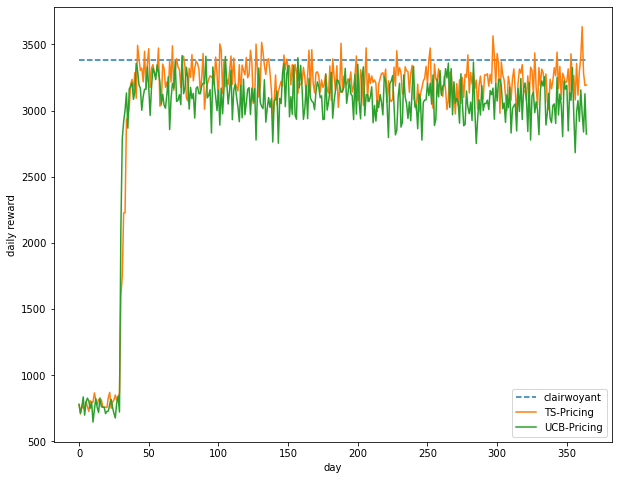

In [10]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*365, '--', label='clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)
plt.legend(loc='best')
plt.show()